In [14]:
from pyspark.sql import SparkSession 
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Create a Spark session
spark = SparkSession.builder.appName("Covid_19_india").getOrCreate()


In [4]:
# Read CSV files
state_df = spark.read.csv("./Datasets/StatewiseTestingDetails.csv", header=True, inferSchema=True)
country_df = spark.read.csv("./Datasets/covid_19_india.csv", header=True, inferSchema=True)

In [5]:
# Select rows for 'Maharashtra' from state_df
maharashtra_state_df = state_df.filter(state_df['State'] == 'Maharashtra').limit(5)


In [6]:
# Select rows for 'Maharashtra' on a specific date from country_df
maharashtra_country_df = country_df.filter((country_df['Date'] == '2020-04-04') &
                                           (country_df['State/UnionTerritory'] == 'Maharashtra'))


In [7]:
# Print minimum and maximum dates
country_df.createOrReplaceTempView("country_table")
min_date = spark.sql("SELECT MIN(Date) FROM country_table").collect()[0][0]
max_date = spark.sql("SELECT MAX(Date) FROM country_table").collect()[0][0]
print("Minimum date :", min_date)
print("Maximum date :", max_date)

Minimum date : 2020-01-30
Maximum date : 2021-05-08


In [9]:
# Calculate the count of null values for each column in the DataFrame
df = country_df
null_counts = df.select([F.sum(F.col(column).isNull().cast(IntegerType())).alias(column) for column in df.columns])

# Display the count of null values for each column
null_counts.show()


+---+----+----+--------------------+-----------------------+------------------------+-----+------+---------+
|Sno|Date|Time|State/UnionTerritory|ConfirmedIndianNational|ConfirmedForeignNational|Cured|Deaths|Confirmed|
+---+----+----+--------------------+-----------------------+------------------------+-----+------+---------+
|  0|   0|   0|                   0|                      0|                       0|    0|     0|        0|
+---+----+----+--------------------+-----------------------+------------------------+-----+------+---------+



In [10]:
df.show()

+---+----------+-------+--------------------+-----------------------+------------------------+-----+------+---------+
|Sno|      Date|   Time|State/UnionTerritory|ConfirmedIndianNational|ConfirmedForeignNational|Cured|Deaths|Confirmed|
+---+----------+-------+--------------------+-----------------------+------------------------+-----+------+---------+
|  1|2020-01-30|6:00 PM|              Kerala|                      1|                       0|    0|     0|        1|
|  2|2020-01-31|6:00 PM|              Kerala|                      1|                       0|    0|     0|        1|
|  3|2020-02-01|6:00 PM|              Kerala|                      2|                       0|    0|     0|        2|
|  4|2020-02-02|6:00 PM|              Kerala|                      3|                       0|    0|     0|        3|
|  5|2020-02-03|6:00 PM|              Kerala|                      3|                       0|    0|     0|        3|
|  6|2020-02-04|6:00 PM|              Kerala|           

In [17]:
from pyspark.sql.functions import to_date, col

# Convert 'Date' column to a DateType using to_date()
df = df.withColumn('Date', to_date('Date', 'yyyy-MM-dd'))

# Drop the 'Time' column
columns_to_drop = ['Time']
df = df.drop(*columns_to_drop)

# Rename the 'State/UnionTerritory' column to 'States'
df = df.withColumnRenamed('State/UnionTerritory', 'States')

In [16]:
# Create the 'Active_cases' column
df = df.withColumn('Active_cases', col('Confirmed') - (col('Cured') + col('Deaths')))

In [18]:
# Filter rows where 'States' is 'Tamil Nadu', order by 'Date' in descending order, and limit the result
tamil_nadu_data = df.filter(col('States') == 'Tamil Nadu').orderBy(col('Date').desc()).limit(5)

tamil_nadu_data.show()

+-----+----------+----------+-----------------------+------------------------+-------+------+---------+------------+
|  Sno|      Date|    States|ConfirmedIndianNational|ConfirmedForeignNational|  Cured|Deaths|Confirmed|Active_cases|
+-----+----------+----------+-----------------------+------------------------+-------+------+---------+------------+
|14685|2021-05-08|Tamil Nadu|                      -|                       -|1173439| 15171|  1323965|      135355|
|14649|2021-05-07|Tamil Nadu|                      -|                       -|1151058| 14974|  1297500|      131468|
|14613|2021-05-06|Tamil Nadu|                      -|                       -|1129512| 14779|  1272602|      128311|
|14577|2021-05-05|Tamil Nadu|                      -|                       -|1109450| 14612|  1249292|      125230|
|14541|2021-05-04|Tamil Nadu|                      -|                       -|1090338| 14468|  1228064|      123258|
+-----+----------+----------+-----------------------+-----------

# EDA (Exploratory Data Analysis) & Future Engineering

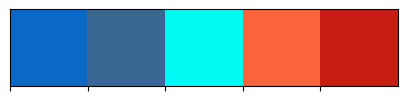

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mtd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# Define colors
colors = ['#0C68C7', '#3A6794', '#00FAF3', '#FA643C', '#C71D12']

# Set Seaborn palette (local visualization)
sns.set_palette(sns.color_palette(colors))

# Display the palette (optional)
sns.palplot(colors)

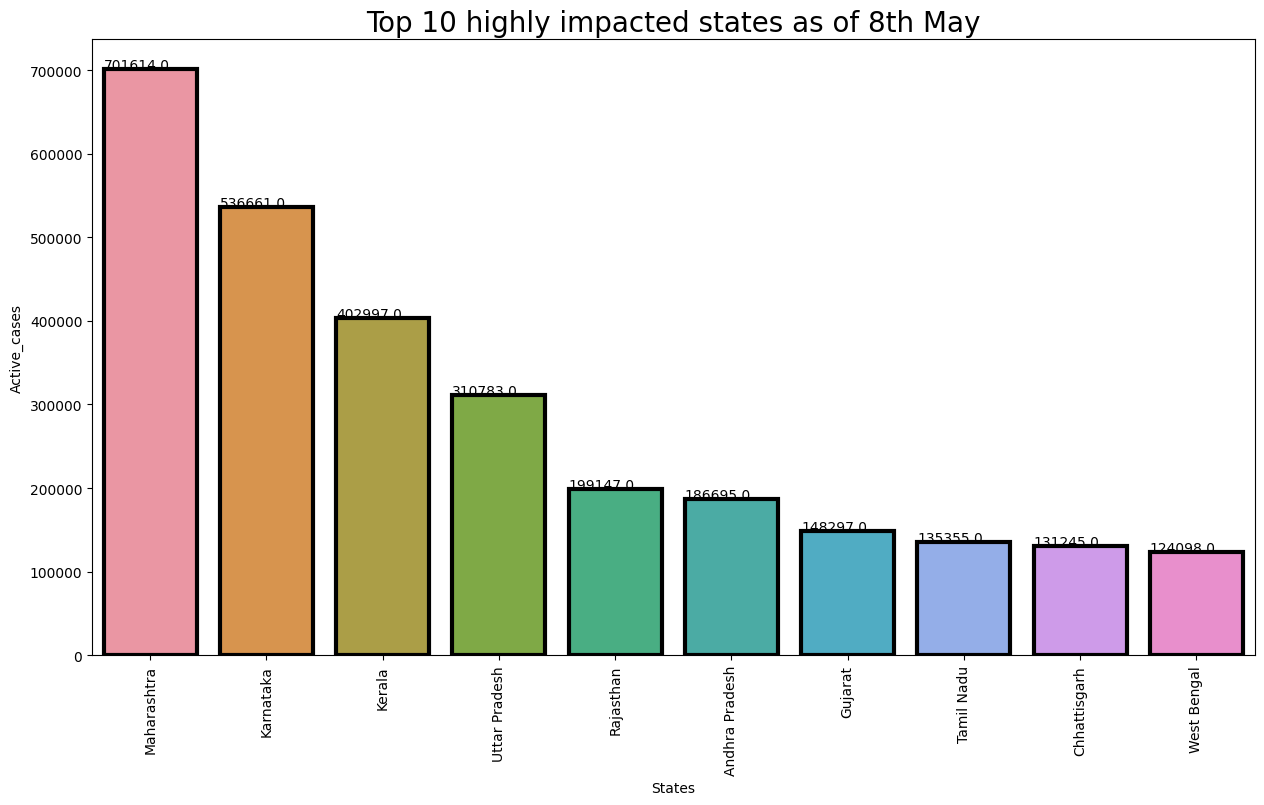

In [24]:
# Assuming 'df' is your Spark DataFrame

# Group by 'States' and aggregate maximum 'Active_cases' and 'Date'
grouped_df = df.groupBy('States').agg({'Active_cases': 'max', 'Date': 'max'})

# Rename columns
grouped_df = grouped_df.withColumnRenamed('max(Active_cases)', 'Active_cases').withColumnRenamed('max(Date)', 'Date')

# Sort by 'Active_cases' in descending order and limit to top 10
top_10 = grouped_df.orderBy(col('Active_cases').desc()).limit(10).toPandas()

# Set up Matplotlib figure
fig = plt.figure(figsize=(15, 8))
plt.title("Top 10 highly impacted states as of 8th May", size=20)

# Create bar plot using Matplotlib
ax = sns.barplot(data=top_10, y='Active_cases', x='States', linewidth=3, edgecolor='black')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

# Add height values to the bars
for i in ax.patches:
    ax.text(x=i.get_x(), y=i.get_height(), s=i.get_height())

# Show the plot
plt.show()

***As on May 8th Data, Maharastra has highest number active cases and comes the Karnataka, Kerala, Utttar Pradesh & Rajasthan**

Text(0.5, 1.0, 'Active cases by States')

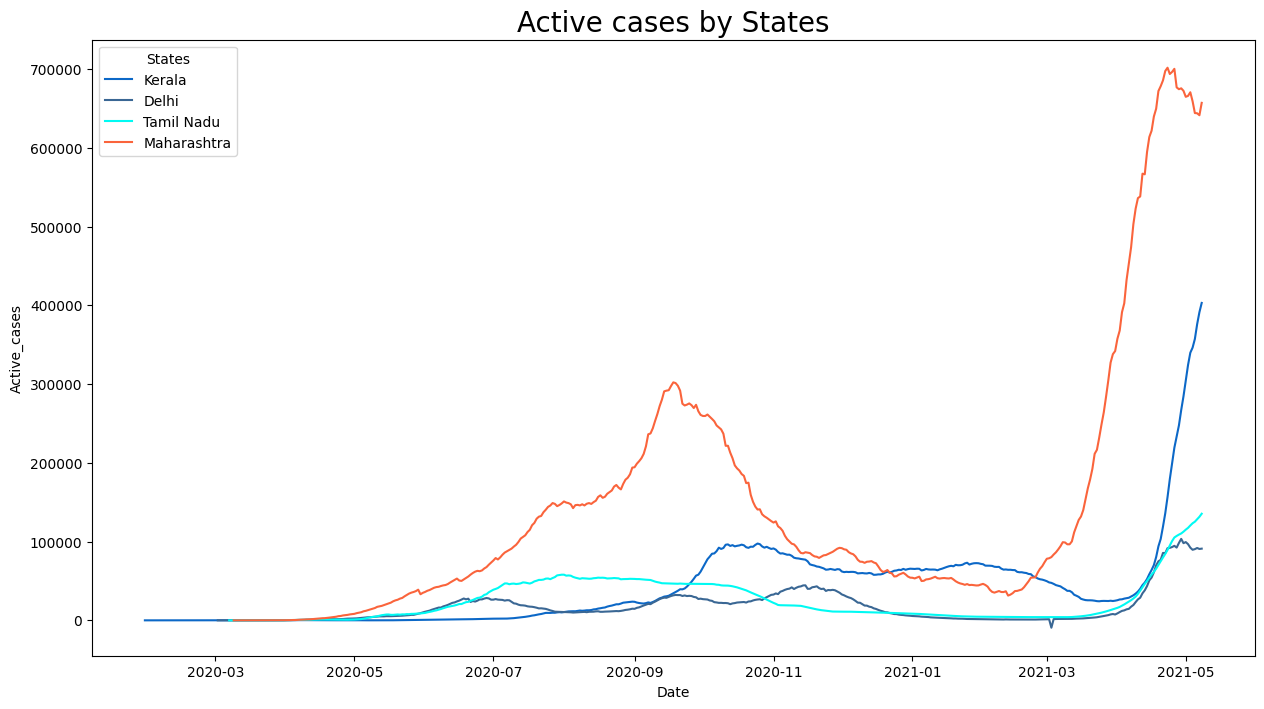

In [25]:
# Filter data for specific states
selected_states = ['Kerala', 'Tamil Nadu', 'Delhi', 'Maharashtra']
filtered_df = df.filter(col('States').isin(selected_states))

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = filtered_df.toPandas()

# Set up Matplotlib figure
fig = plt.figure(figsize=(15, 8))

# Create line plot using Seaborn (based on Pandas DataFrame)
ax = sns.lineplot(data=pandas_df, x='Date', y='Active_cases', hue='States')
ax.set_title("Active cases by States", size=20)

# Display the plot using display() in a Spark environment

**Almost all states shares the same trend in Covid cases, as mentioned in the above chart, Maharastra has highes number cases since july 2020.**

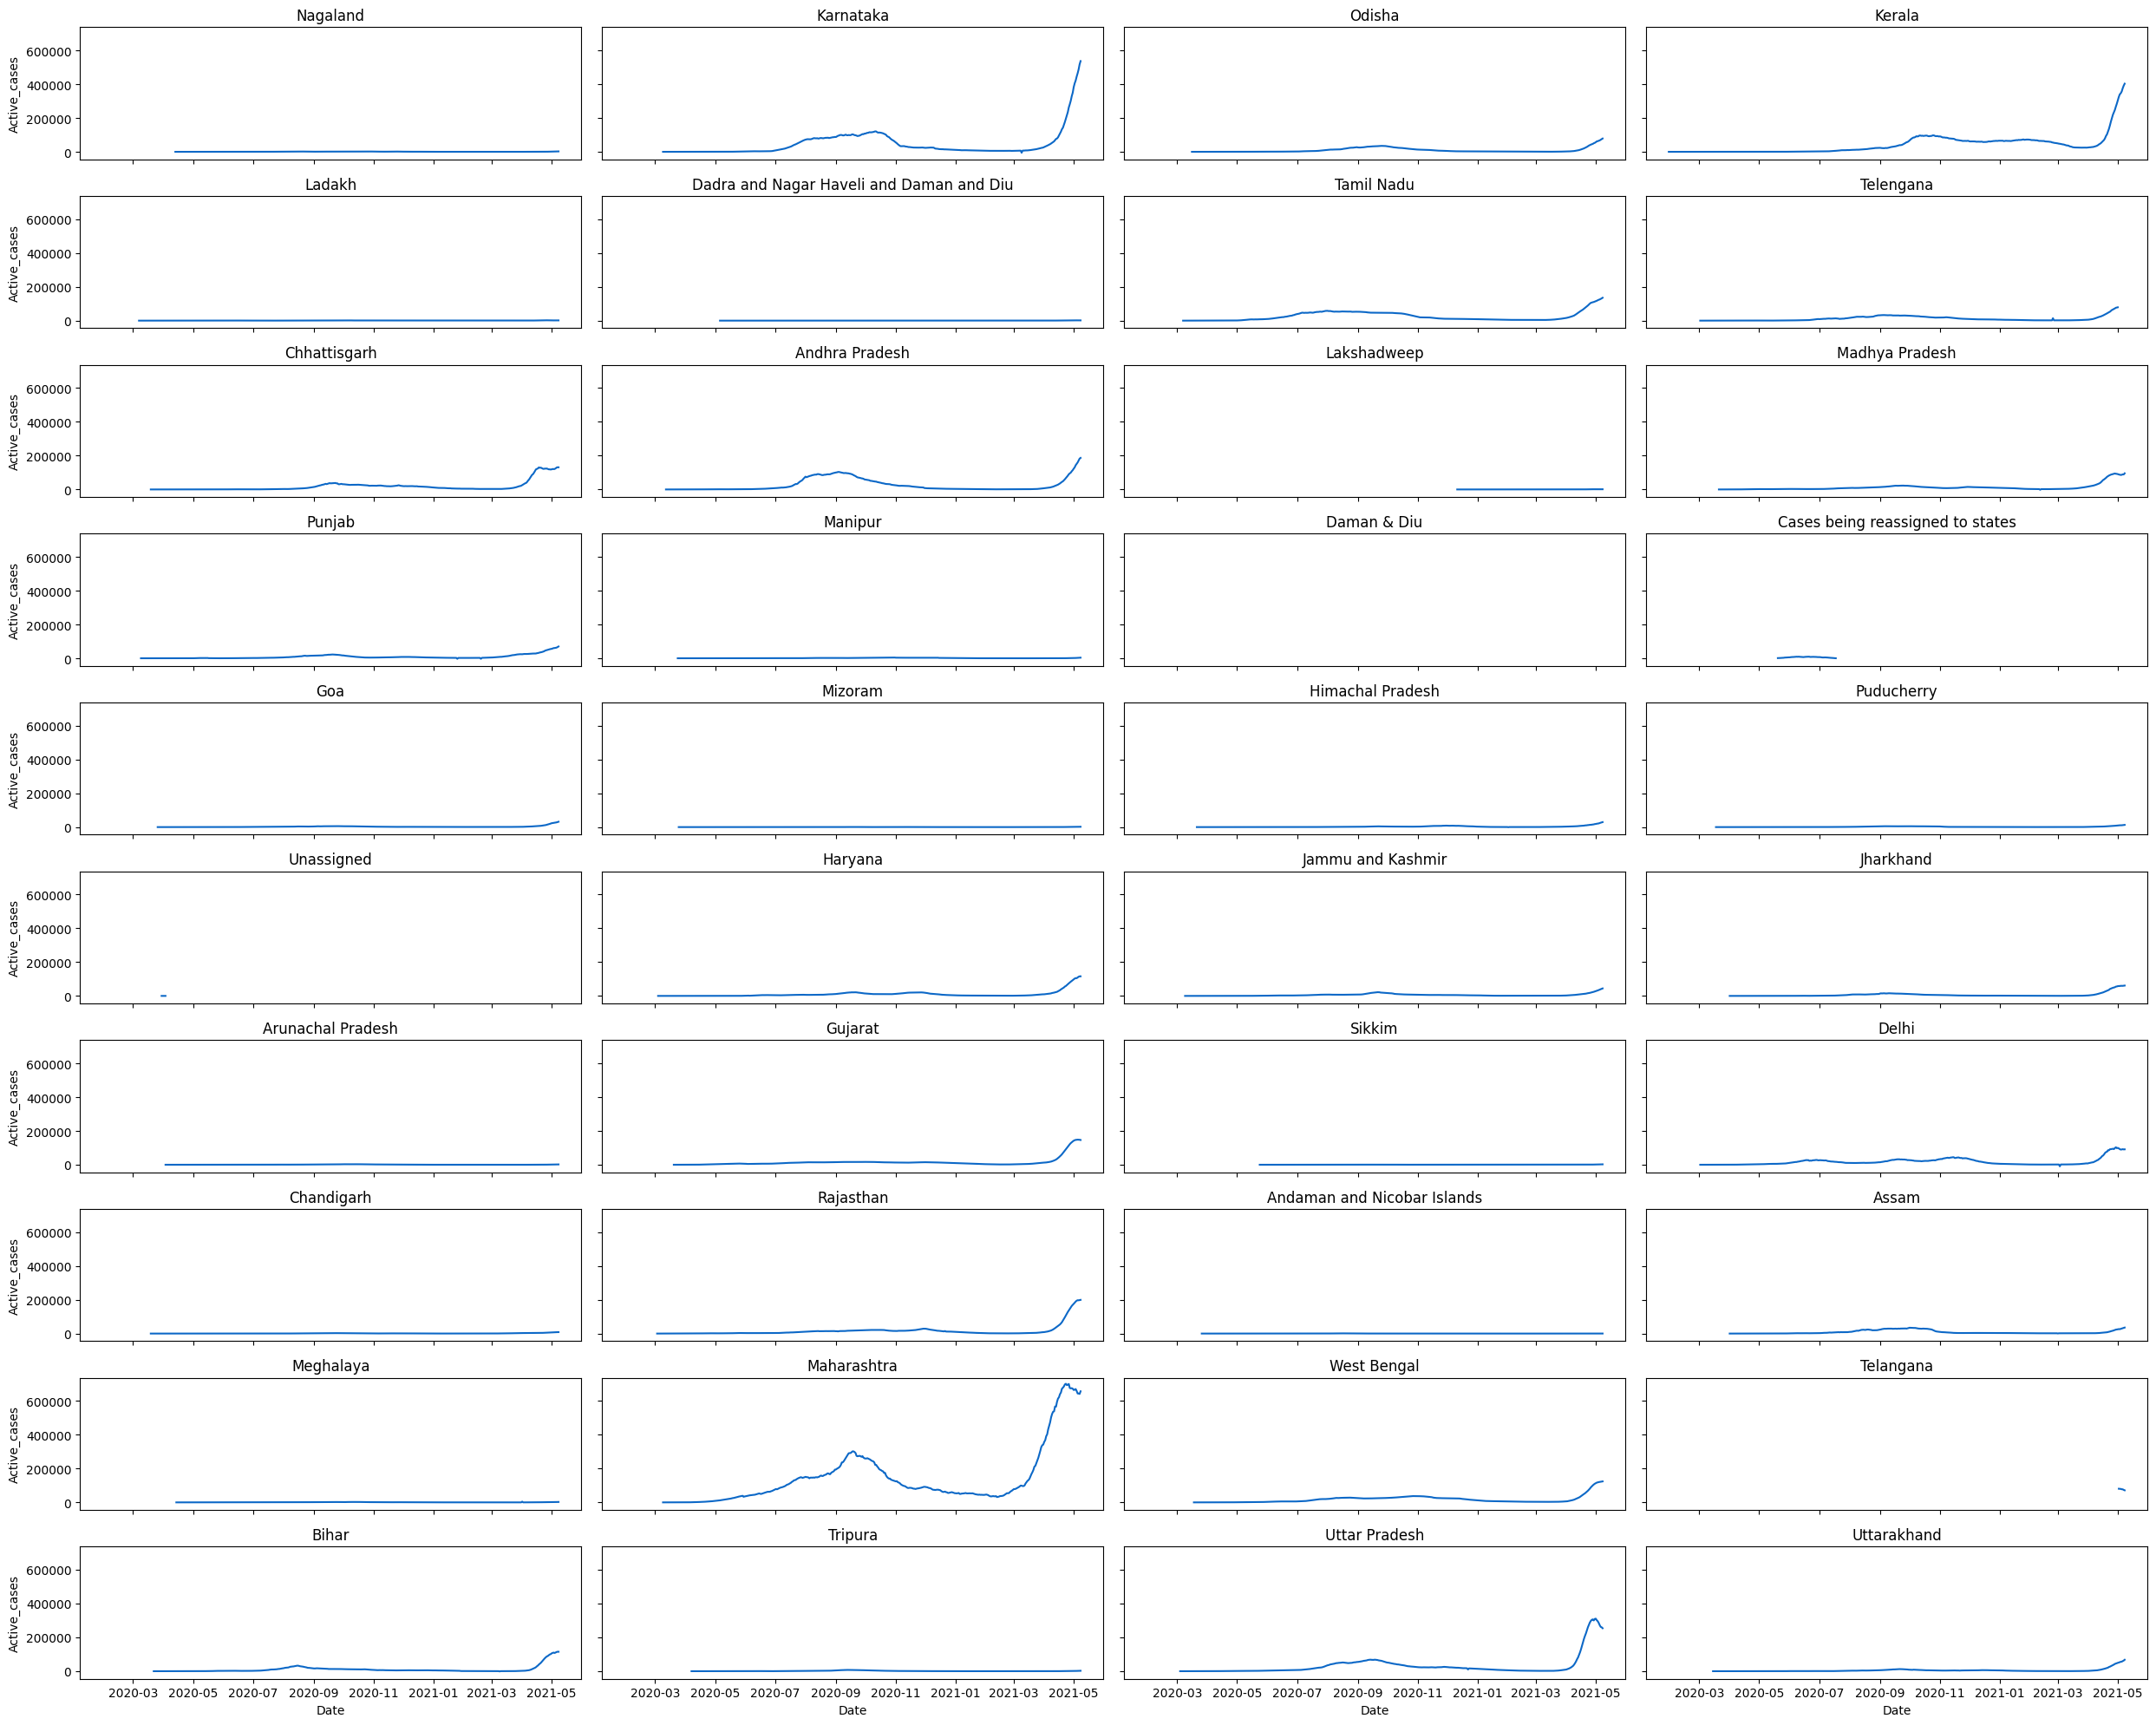

In [26]:
# Collect unique state values
unique_states = [row['States'] for row in df.select('States').distinct().collect()]

# Set up Matplotlib subplots
fig, ax = plt.subplots(nrows=10, ncols=4, figsize=[25, 20], sharex=True, sharey=True)
ax = ax.flatten()

# Loop through unique states and create line plots
for i, s in enumerate(unique_states):
    data1 = df.filter(col('States') == s).select('Date', 'Active_cases').toPandas()
    sns.lineplot(data=data1, x='Date', y='Active_cases', ax=ax[i])
    ax[i].set_title(s)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Box plot for sample states')

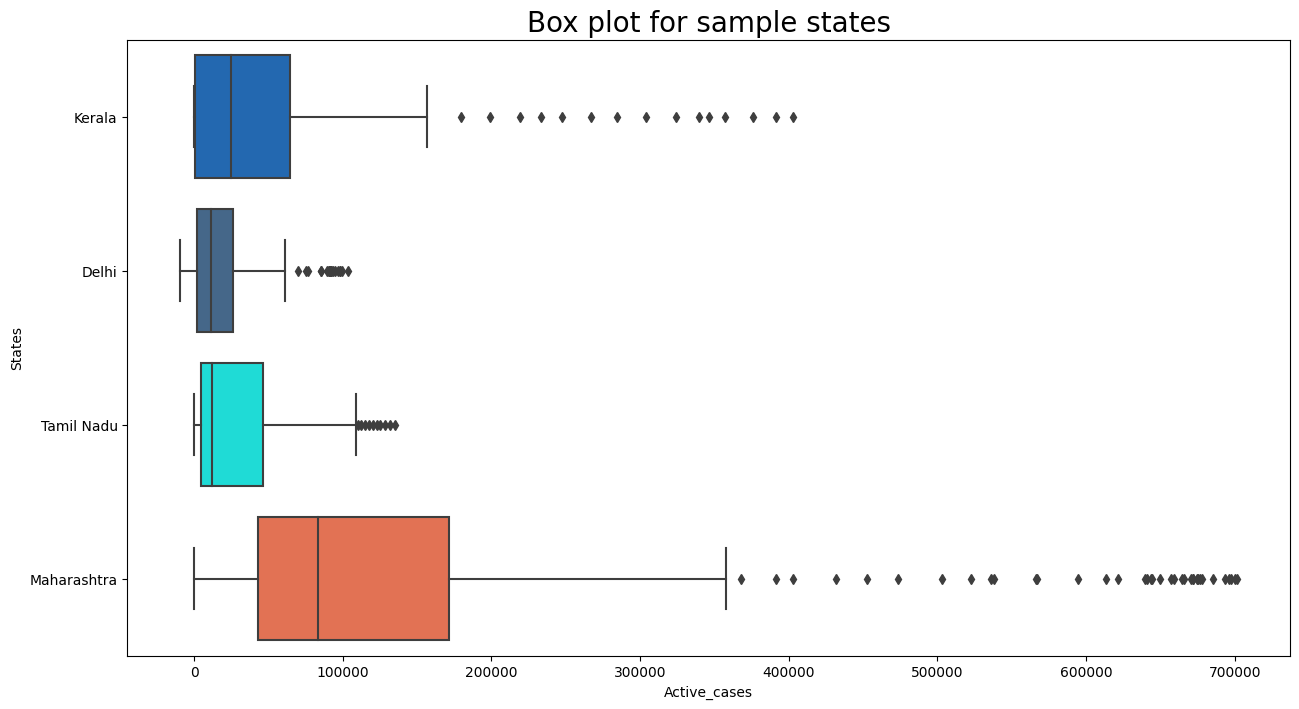

In [28]:

# Assuming 'df' is your Spark DataFrame

# Collect data for specific states
selected_states = ['Kerala', 'Tamil Nadu', 'Delhi', 'Maharashtra']
filtered_df = df.filter(col('States').isin(selected_states))

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = filtered_df.toPandas()

# Set up Matplotlib figure
fig = plt.figure(figsize=(15, 8))

# Create box plot using Seaborn (based on Pandas DataFrame)
sns.boxplot(data=pandas_df, x='Active_cases', y='States')
plt.title("Box plot for sample states", size=20)



***Observation:***
1. Maharastra - Most of the times Active cases stays between 50000, 190000 range and the range went upto 35000+. Median is around 83K cases
2. Kerala - Active cases ranging from 0 to less than 100000. Median is around 40. Median value is around 24K
3. Tamilnadu - Avtive cases in Tamilnadu ranging less than 50,000. Median is around 12K

Is it because of high rate for cure/deaths?. lets check the same

Text(0.5, 1.0, 'Box plot for sample states')

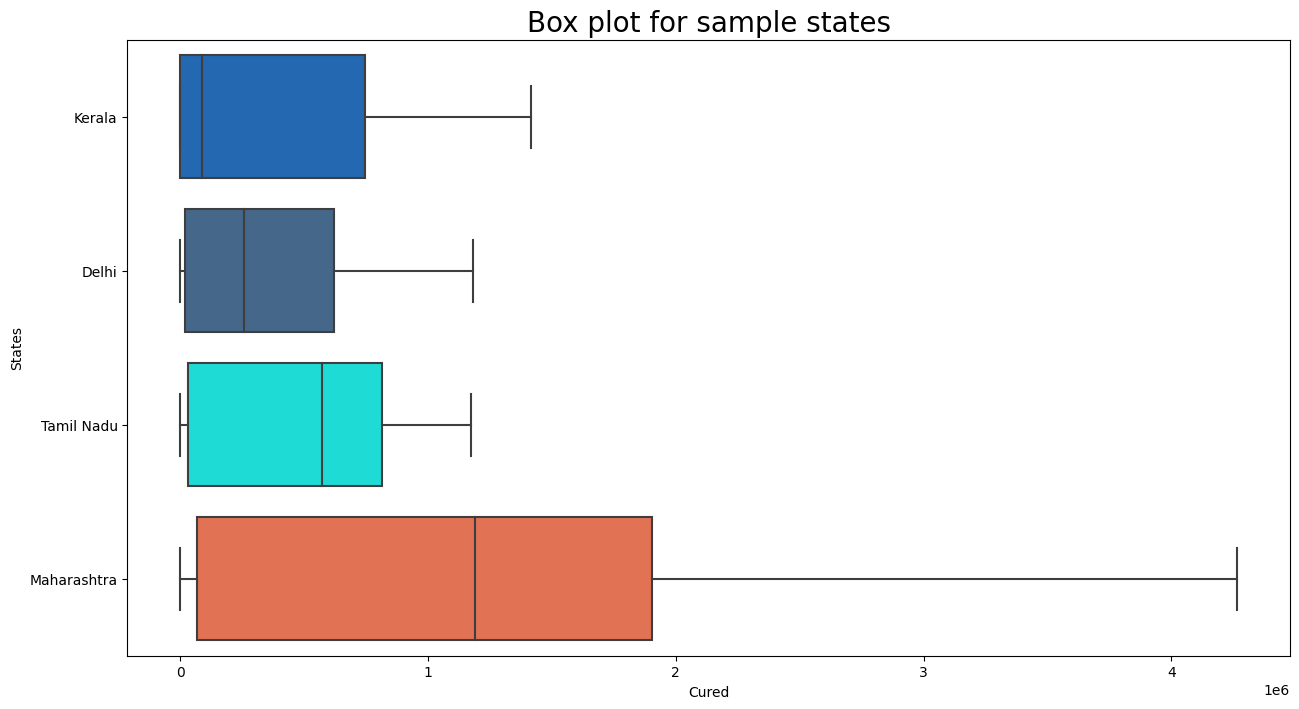

In [30]:
# Collect data for specific states
selected_states = ['Kerala', 'Tamil Nadu', 'Delhi', 'Maharashtra']
filtered_df = df.filter(col('States').isin(selected_states))

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = filtered_df.toPandas()

# Set up Matplotlib figure
fig = plt.figure(figsize=(15, 8))

# Create box plot using Seaborn (based on Pandas DataFrame)
sns.boxplot(data=pandas_df, x='Cured', y='States')
plt.title("Box plot for sample states", size=20)

# Display the plot using display() in a Spark environment


**Observation**

1. Maharastra - has high range of cured value as well. 
2. Kerala - is in 3rd place for cured count
3. Tamilnadu - is in 2nd place in the sample in terms of cure.  

But, we can't conclude the rate by count. We will do some testing

<Axes: xlabel='Date', ylabel='Deaths'>

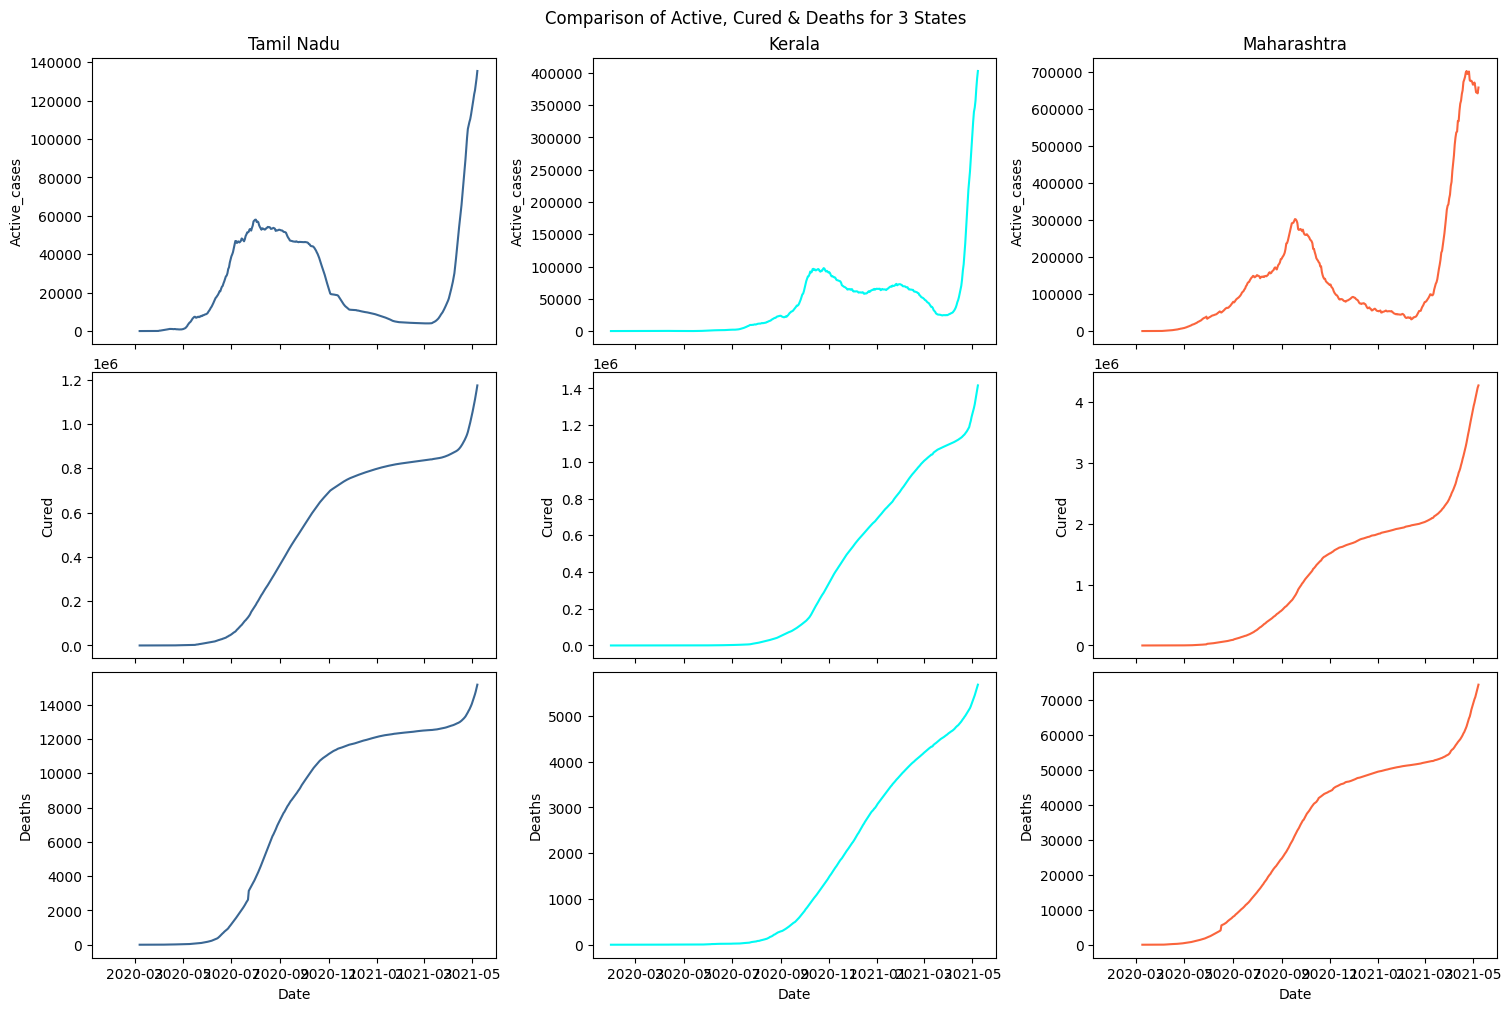

In [31]:
# Filter data for the specified states
states = ['Kerala', 'Tamil Nadu', 'Maharashtra']
tn = df.filter(col('States') == 'Tamil Nadu')
kl = df.filter(col('States') == 'Kerala')
mh = df.filter(col('States') == 'Maharashtra')

# Set up Matplotlib figure using Seaborn style
sns.set_palette(colors)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), squeeze=False, sharex=True, sharey=False, constrained_layout=True)
plt.suptitle("Comparison of Active, Cured & Deaths for 3 States")

# Line plots for Tamil Nadu
sns.lineplot(data=tn.toPandas(), x='Date', y='Active_cases', ax=ax[0, 0], color=colors[1])
ax[0, 0].set_title("Tamil Nadu")
sns.lineplot(data=tn.toPandas(), x='Date', y='Cured', ax=ax[1, 0], color=colors[1])
sns.lineplot(data=tn.toPandas(), x='Date', y='Deaths', ax=ax[2, 0], color=colors[1])

# Line plots for Kerala
sns.lineplot(data=kl.toPandas(), x='Date', y='Active_cases', ax=ax[0, 1], color=colors[2])
ax[0, 1].set_title("Kerala")
sns.lineplot(data=kl.toPandas(), x='Date', y='Cured', ax=ax[1, 1], color=colors[2])
sns.lineplot(data=kl.toPandas(), x='Date', y='Deaths', ax=ax[2, 1], color=colors[2])

# Line plots for Maharashtra
sns.lineplot(data=mh.toPandas(), x='Date', y='Active_cases', ax=ax[0, 2], color=colors[3])
ax[0, 2].set_title("Maharashtra")
sns.lineplot(data=mh.toPandas(), x='Date', y='Cured', ax=ax[1, 2], color=colors[3])
sns.lineplot(data=mh.toPandas(), x='Date', y='Deaths', ax=ax[2, 2], color=colors[3])



<Axes: xlabel='Deaths', ylabel='Density'>

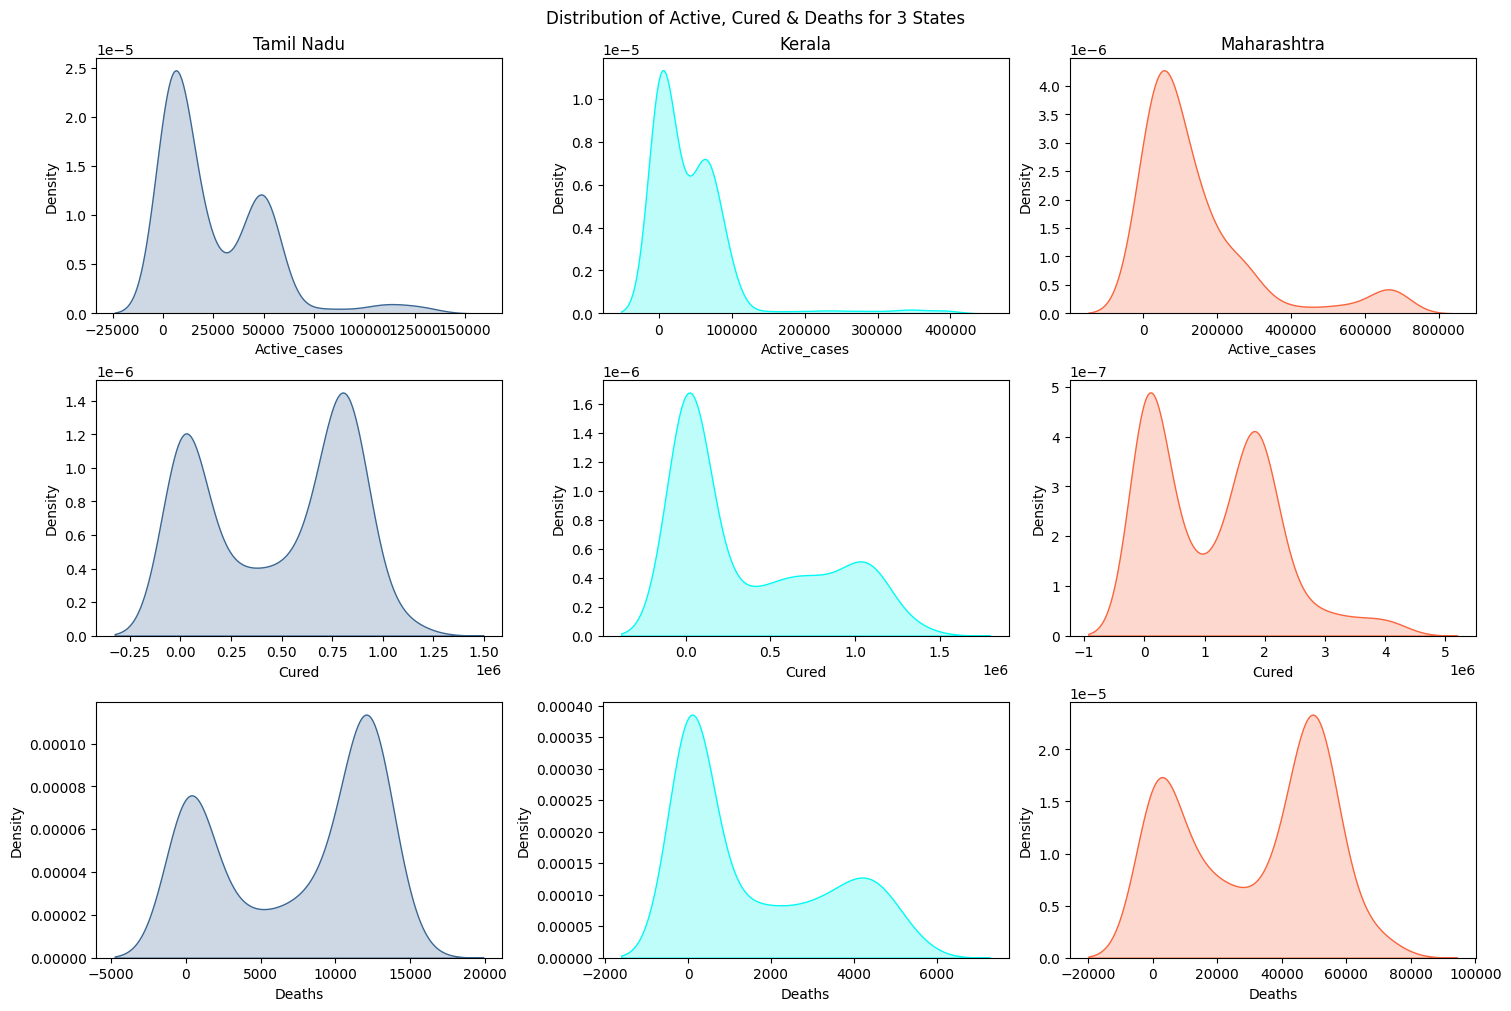

In [32]:
# Filter data for the specified states
states = ['Kerala', 'Tamil Nadu', 'Maharashtra']
tn = df.filter(col('States') == 'Tamil Nadu')
kl = df.filter(col('States') == 'Kerala')
mh = df.filter(col('States') == 'Maharashtra')

# Set up Matplotlib figure using Seaborn style
sns.set_palette(colors)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), squeeze=False, sharex=False, sharey=False, constrained_layout=True)
plt.suptitle("Distribution of Active, Cured & Deaths for 3 States")

# KDE plots for Tamil Nadu
sns.kdeplot(data=tn.toPandas()['Active_cases'], ax=ax[0, 0], color=colors[1], fill=True)
ax[0, 0].set_title("Tamil Nadu")
sns.kdeplot(data=tn.toPandas()['Cured'], ax=ax[1, 0], color=colors[1], fill=True)
sns.kdeplot(data=tn.toPandas()['Deaths'], ax=ax[2, 0], color=colors[1], fill=True)

# KDE plots for Kerala
sns.kdeplot(data=kl.toPandas()['Active_cases'], ax=ax[0, 1], color=colors[2], fill=True)
ax[0, 1].set_title("Kerala")
sns.kdeplot(data=kl.toPandas()['Cured'], ax=ax[1, 1], color=colors[2], fill=True)
sns.kdeplot(data=kl.toPandas()['Deaths'], ax=ax[2, 1], color=colors[2], fill=True)

# KDE plots for Maharashtra
sns.kdeplot(data=mh.toPandas()['Active_cases'], ax=ax[0, 2], color=colors[3], fill=True)
ax[0, 2].set_title("Maharashtra")
sns.kdeplot(data=mh.toPandas()['Cured'], ax=ax[1, 2], color=colors[3], fill=True)
sns.kdeplot(data=mh.toPandas()['Deaths'], ax=ax[2, 2], color=colors[3], fill=True)

